<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 42

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 10

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 50
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.0005
METRICAS    = ['accuracy']

ITERACOES = 3

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE, stratify=y_train_val)

In [12]:
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [13]:
# X_train.dtype, X_val.dtype, y_train.dtype, y_val.dtype

### Converter texto em números

In [14]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [15]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [16]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [17]:
# vetorizador.adapt(X_train)
vetorizador.adapt(X)

In [18]:
# texto = random.choice(X_train)
# print(texto)

# vet = vetorizador([texto])

In [19]:
# with np.printoptions(threshold=np.inf):
#     print(vet)

In [20]:
vocabulario = vetorizador.get_vocabulary()

In [21]:
# [UNK] = Desconhecido, fora do limite do dicionário.
# len(vocabulario), vocabulario[:10], vocabulario[-10:]

#### Incorporação (Embedding)

In [22]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [23]:
# texto = random.choice(X_train)
# print(texto)

# incorporador(vetorizador([texto]))

## Funções

In [24]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelo_nome)

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

## Modelos

In [25]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [26]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      1103
           1       0.60      0.79      0.68       830

    accuracy                           0.68      1933
   macro avg       0.69      0.69      0.68      1933
weighted avg       0.71      0.68      0.68      1933



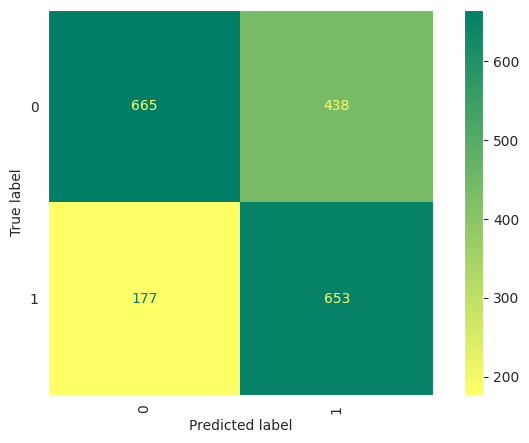

In [28]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [29]:
relatorios[modelo_numero]

{'acuracia': 0.6818416968442835,
 'precisao': 0.7076652728288632,
 'revocacao': 0.6818416968442835,
 'pontuacao-f1': 0.6821083937915633}

### Camadas iniciais padronizadas

In [30]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 48.6 ms, sys: 2.27 ms, total: 50.9 ms
Wall time: 49.2 ms


### Modelo 1: MLP

In [31]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 43s 336ms/step - loss: 0.6700 - accuracy: 0.7108 - val_loss: 0.6409 - val_accuracy: 0.8267
Epoch 2/3
121/121 [==============================] - 27s 224ms/step - loss: 0.5994 - accuracy: 0.8678 - val_loss: 0.5630 - val_accuracy: 0.8660
Epoch 3/3
121/121 [==============================] - 25s 207ms/step - loss: 0.5034 - accuracy: 0.8770 - val_loss: 0.4778 - val_accuracy: 0.8665
CPU times: user 1min 3s, sys: 1.48 s, total: 1min 5s
Wall time: 1min 35s


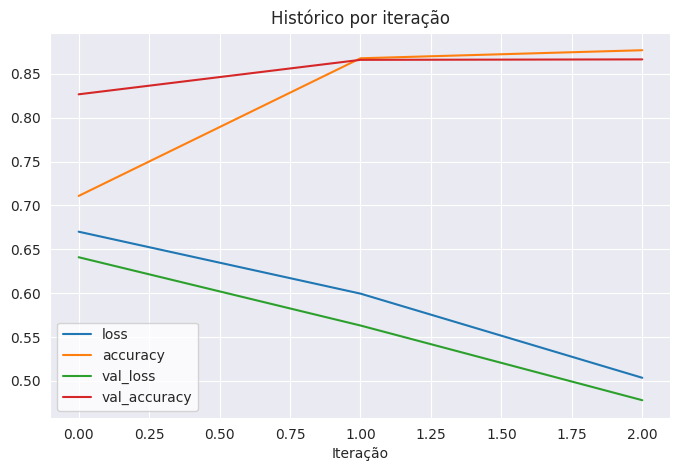

In [32]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1103
           1       0.92      0.76      0.83       830

    accuracy                           0.87      1933
   macro avg       0.88      0.85      0.86      1933
weighted avg       0.87      0.87      0.86      1933



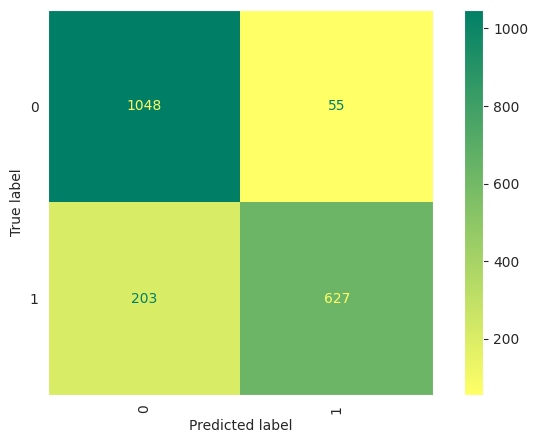

In [33]:
dados_modelo(modelo_numero)

In [34]:
relatorios[modelo_numero]

{'acuracia': 0.8665287118468702,
 'precisao': 0.8727783255764429,
 'revocacao': 0.8665287118468702,
 'pontuacao-f1': 0.8641921708072334}

### Modelo 2: SVM

In [35]:
# %%time

# modelo_numero += 1

# modelo_nome = f'modelo_{modelo_numero}_svm'

# modelos[modelo_numero] = SVC()

# modelos[modelo_numero].fit(X_train, y_train)
# modelos[modelo_numero].fit(incorporador(vetorizador(X_train)).numpy(), y_train)

In [36]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [37]:
# dados_modelo(modelo_numero)

In [38]:
# relatorios[modelo_numero]

### Modelo 3: DT

In [39]:
# %%time

# modelo_numero += 1

# modelo_nome = f'modelo_{modelo_numero}_dt'

# modelos[modelo_numero] = DecisionTreeClassifier()

# modelos[modelo_numero].fit(X_train, y_train)
# modelos[modelo_numero].fit(incorporador(vetorizador(X_train)).numpy(), y_train)

In [40]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [41]:
# dados_modelo(modelo_numero)

In [42]:
# relatorios[modelo_numero]

### Modelo 4: CNN

In [43]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 33s 247ms/step - loss: 0.5614 - accuracy: 0.7540 - val_loss: 0.3977 - val_accuracy: 0.8650
Epoch 2/3
121/121 [==============================] - 25s 206ms/step - loss: 0.2748 - accuracy: 0.9014 - val_loss: 0.2875 - val_accuracy: 0.8758
Epoch 3/3
121/121 [==============================] - 26s 214ms/step - loss: 0.1177 - accuracy: 0.9581 - val_loss: 0.2644 - val_accuracy: 0.8857
CPU times: user 1min 3s, sys: 1.55 s, total: 1min 4s
Wall time: 1min 24s


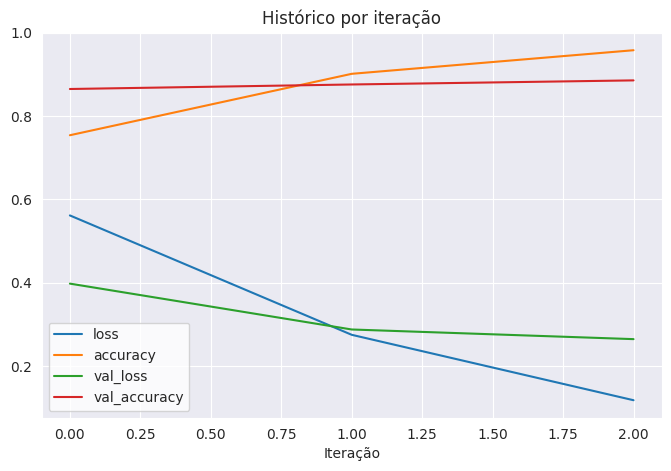

In [44]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1103
           1       0.87      0.86      0.87       830

    accuracy                           0.89      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.89      0.89      0.89      1933



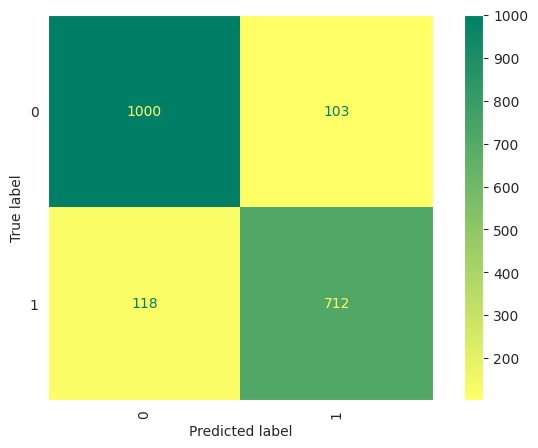

In [45]:
dados_modelo(modelo_numero)

In [46]:
relatorios[modelo_numero]

{'acuracia': 0.8856699430936368,
 'precisao': 0.8855082662887379,
 'revocacao': 0.8856699430936368,
 'pontuacao-f1': 0.8855347577200241}

### Modelo 5: DCNN

In [47]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_dcnn'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 31s 231ms/step - loss: 0.3358 - accuracy: 0.8806 - val_loss: 0.2728 - val_accuracy: 0.8893
Epoch 2/3
121/121 [==============================] - 25s 210ms/step - loss: 0.0801 - accuracy: 0.9744 - val_loss: 0.2587 - val_accuracy: 0.8986
Epoch 3/3
121/121 [==============================] - 25s 203ms/step - loss: 0.0199 - accuracy: 0.9946 - val_loss: 0.2879 - val_accuracy: 0.9043
CPU times: user 1min 2s, sys: 1.3 s, total: 1min 3s
Wall time: 1min 23s


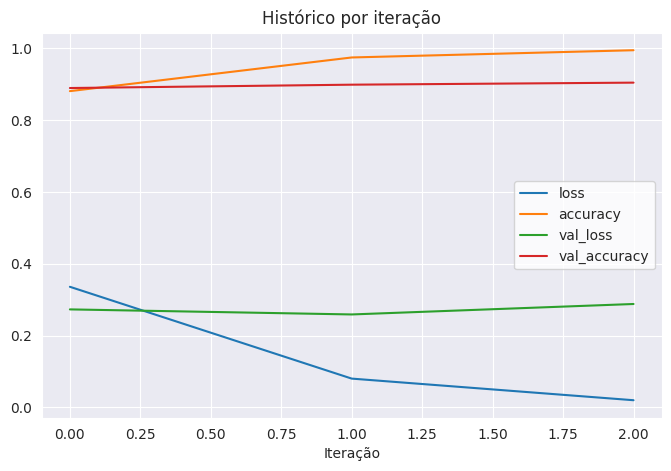

In [48]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1103
           1       0.92      0.85      0.88       830

    accuracy                           0.90      1933
   macro avg       0.91      0.90      0.90      1933
weighted avg       0.91      0.90      0.90      1933



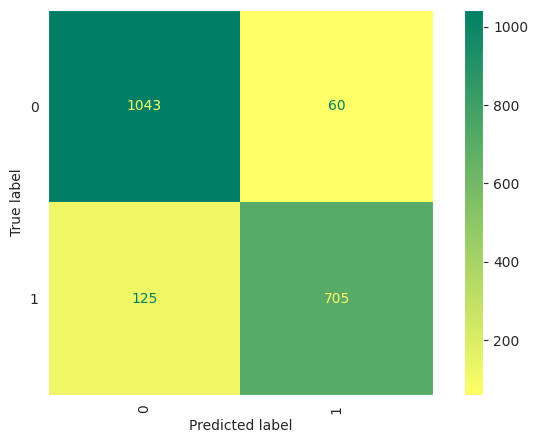

In [49]:
dados_modelo(modelo_numero)

In [50]:
relatorios[modelo_numero]

{'acuracia': 0.9042938437661666,
 'precisao': 0.9052551973102702,
 'revocacao': 0.9042938437661666,
 'pontuacao-f1': 0.9037133572854185}

### Modelo 6: RNN (LSTM Bidirecional)

In [51]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_rnn'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 40s 294ms/step - loss: 0.3485 - accuracy: 0.8406 - val_loss: 0.3221 - val_accuracy: 0.8815
Epoch 2/3
121/121 [==============================] - 33s 271ms/step - loss: 0.0781 - accuracy: 0.9793 - val_loss: 0.3349 - val_accuracy: 0.8883
Epoch 3/3
121/121 [==============================] - 33s 274ms/step - loss: 0.0647 - accuracy: 0.9816 - val_loss: 0.5363 - val_accuracy: 0.8619
CPU times: user 1min 31s, sys: 2.47 s, total: 1min 33s
Wall time: 1min 46s


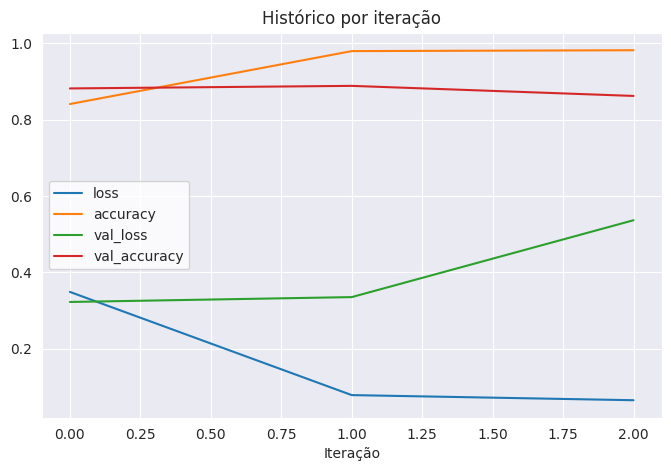

In [52]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1103
           1       0.93      0.73      0.82       830

    accuracy                           0.86      1933
   macro avg       0.88      0.85      0.85      1933
weighted avg       0.87      0.86      0.86      1933



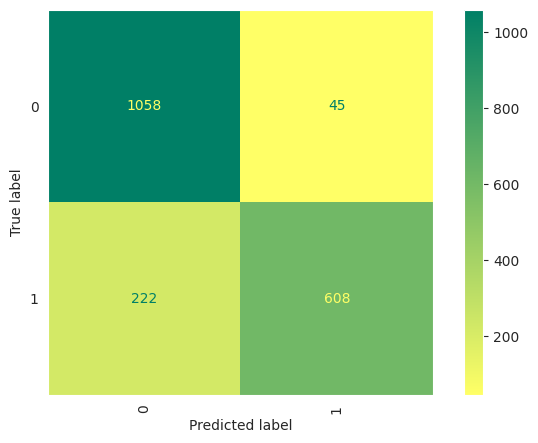

In [53]:
dados_modelo(modelo_numero)

In [54]:
relatorios[modelo_numero]

{'acuracia': 0.8618727366787378,
 'precisao': 0.8714438115518413,
 'revocacao': 0.8618727366787378,
 'pontuacao-f1': 0.8587595870555955}

### Modelo 7: Transformer

In [55]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/3
121/121 [==============================] - 86s 590ms/step - loss: 0.5997 - accuracy: 0.6744 - val_loss: 0.4848 - val_accuracy: 0.7693
Epoch 2/3
121/121 [==============================] - 64s 529ms/step - loss: 0.4212 - accuracy: 0.8080 - val_loss: 0.4238 - val_accuracy: 0.8044
Epoch 3/3
121/121 [==============================] - 62s 511ms/step - loss: 0.3239 - accuracy: 0.8624 - val_loss: 0.5183 - val_accuracy: 0.7894
CPU times: user 3min 43s, sys: 20.7 s, total: 4min 3s
Wall time: 4min 36s


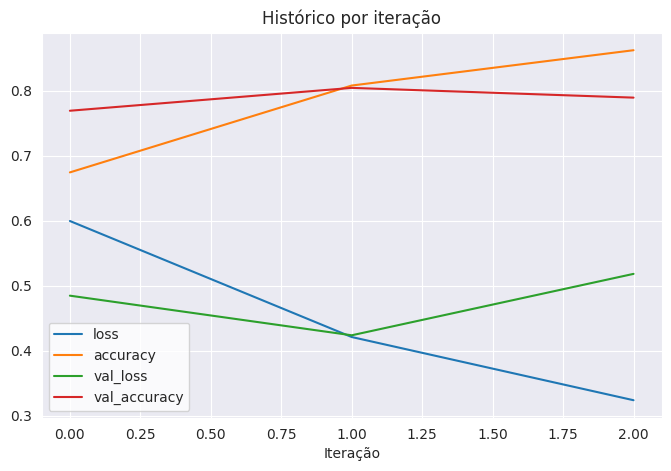

In [56]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 9s 148ms/step
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1103
           1       0.73      0.82      0.77       830

    accuracy                           0.79      1933
   macro avg       0.79      0.79      0.79      1933
weighted avg       0.80      0.79      0.79      1933



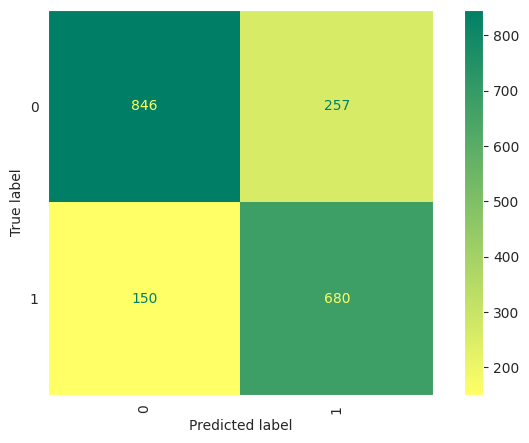

In [57]:
dados_modelo(modelo_numero)

In [58]:
relatorios[modelo_numero]

{'acuracia': 0.7894464562855664,
 'precisao': 0.7962925302942315,
 'revocacao': 0.7894464562855664,
 'pontuacao-f1': 0.7904547926570932}

## Comparar modelos

In [59]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

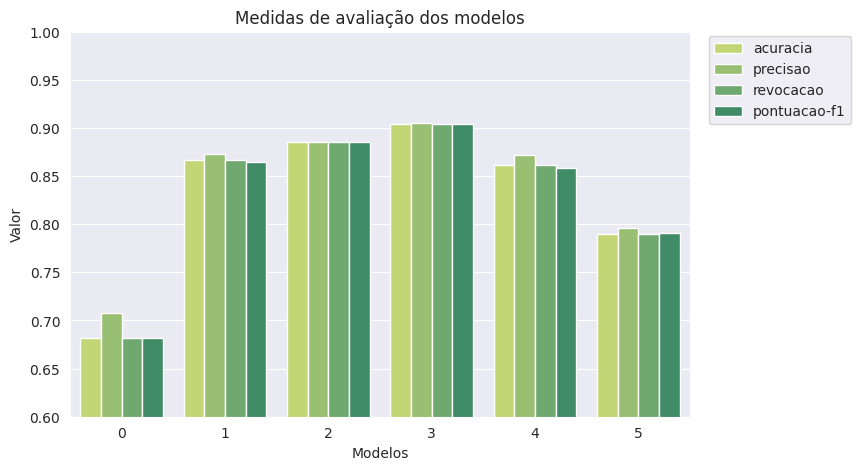

In [60]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.6, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));